<script>
        var code_show=true; //true -> hide code at first
    
        function code_toggle() {
            $('div.prompt').hide(); // always hide prompt
            $('div[style*=\"border-style: dashed"\]').hide(); // hide extra comments, usually log from treasuredata
            $('div.output_stderr').parent().hide();
    
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
            code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_context('talk')
sns.set_style('white')

random_state = np.random.RandomState(seed = 144)

In [2]:
df_actigraph = pd.read_csv('../0-dataset/1-preprocessed/actigraph_combined.csv')
df_actigraph.columns = df_actigraph.columns.str.lower().str.strip().str.replace(' ','_')

df_patient_metadata = pd.read_csv('../0-dataset/1-preprocessed/patient_metadata_trimmed.csv')
df_patient_metadata['visit_info'] = np.where(
    (df_patient_metadata['visit'] == 1),
    'baseline',
    'follow-up'
)

In [3]:
conditions = [
    (df_patient_metadata['gender'] == 1),
    (df_patient_metadata['gender'] == 0)
]

choices = [
    'female',
    'male'
]

df_patient_metadata['gender_string'] = np.select(
    conditions,
    choices,
    default = None
)

In [4]:
import datetime

def standardize_date_format(series):
    """
    Standardize date format to YYYY-MM-DD,
    since Actigraph data also contains DD/MM/YYYY and it can not be read correctly by pandas.to_datetime
    """
    input1, input2, input3 = series.split('/')
    if len(input1) == 4:
        return series.replace('/','-')
    else:
        return input3 + '-' + input2 + '-' + input1

In [5]:
df_actigraph['date'] = df_actigraph['date'].apply(standardize_date_format)

In [6]:
## combine with main metadata of the patient
meta = df_patient_metadata.loc[
    (df_patient_metadata['visit'].notnull()),
    [
        'patient_id','visit_info','include_activpal_data','gender_string','age','height','weight','bmi',
        'sf_pf', 'sf_role', 'sf_pain','sf_social', 'sf_mental', 'sf_emot', 'sf_vitality', 
        'sf_gen_health','sf36_total', 'haq'
    ]
].copy().rename(
    columns = {
        'gender_string': 'gender'
    }
)

df_actigraph = df_actigraph.merge(
    meta,
    how = 'left',
    left_on = ['patient_id','directory_name'],
    right_on = ['patient_id','visit_info']
)

In [7]:
df_actigraph['datetime'] = df_actigraph['date'] + ' ' + df_actigraph['time']
for col in ['date','datetime']:
    df_actigraph[col] = pd.to_datetime(df_actigraph[col])
    
df_actigraph['datetime_hour'] = df_actigraph['datetime'].dt.floor('h')
df_actigraph['hour'] = df_actigraph['datetime'].dt.hour

df_actigraph.sort_values(by = ['patient_id','datetime'], inplace = True)

In [8]:
df_actigraph['day_of_week'] = df_actigraph['date'].dt.dayofweek

conditions = [
    (df_actigraph['day_of_week'] == 0),
    (df_actigraph['day_of_week'] == 1),
    (df_actigraph['day_of_week'] == 2),
    (df_actigraph['day_of_week'] == 3),
    (df_actigraph['day_of_week'] == 4),
    (df_actigraph['day_of_week'] == 5),
    (df_actigraph['day_of_week'] == 6)
]

choices = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
]

df_actigraph['day_of_week_string'] = np.select(
    conditions,
    choices,
    default = None
)

In [9]:
## produce the merged data as output
# df_actigraph.to_csv('../0-dataset/1-preprocessed/actigraph_combined_with_metadata.csv', index = False)

# Objectives

1. Identify activity type
2. Identify non-wear period

Both are identified based on vertical axis movement (axis1).

# 1. Identify activity types

> The cutpoints are as follows: 
- sedentary behaviour = <100cpm 
- light intensity: 100-1951 cpm
- moderate intensity: 1952-5724 cpm
- vigorous activity: >5724cpm

**cut-points are based on axis1 (up and down)**

In [54]:
def determine_behavior_by_rule(df, column='axis1'):
    conditions = [
        (df[column] < 100),
        (df[column] >= 100) & (df[column] < 1952),
        (df[column] >= 1952) & (df[column] < 5725),
        (df[column] >= 5725)
    ]

    choices = [
        'sedentary_behavior',
        'light_intensity',
        'moderate',
        'vigorous'
    ]

    result = np.select(
        conditions,
        choices
    )
    
    return result

In [55]:
df_actigraph['behavior_by_rule'] = determine_behavior_by_rule(df_actigraph, column='axis1')

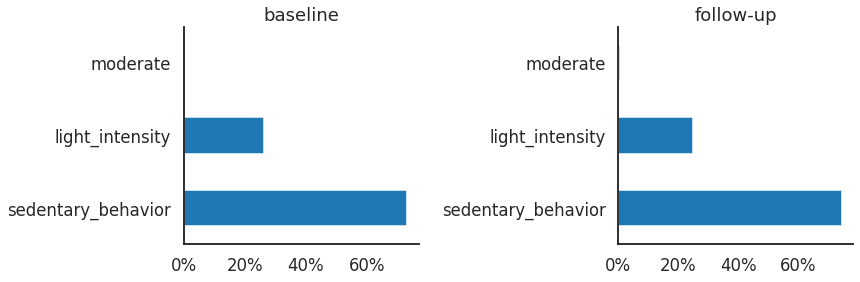

In [57]:
f, ax = plt.subplots(figsize = (12,4), ncols = 2)
plt.subplots_adjust(wspace = .85)
i = 0

for col in ['baseline','follow-up']:
    mask = (df_actigraph['directory_name'] == col)    
    df_actigraph.loc[
        mask,
        'behavior_by_rule'
    ].value_counts(True).plot.barh(ax=ax[i]);
    
    x_values = ax[i].get_xticks()
    ax[i].set_xticklabels(['{:,.0%}'.format(x) for x in x_values])
    ax[i].set_title(col);
    i += 1
    
sns.despine()
plt.show();

# 2. Identify non-wear time

**How to identify non-wear time?**

> - based on rolling average per 90 minutes, find 0 mean with small variance?
> - identifying consecutive steps?

- Non-wear time (i.e device removed for some reason) is defined as **1 min intervals with consecutive zeroes for a minimum of 90 min** (with an allowance of up to 2 min of counts between 0 and 50 (or allowance of 2-min interval of nonzero counts with the upstream or downstream 30-min consecutive zero-count window for detection of artifactual movements.).


> If you have something like this: <br>
> 0 0 0 0 0 0 0 0 (for 50 min) 10 15 10 20 (for 1.5 min) 0 0 0 0 0 0 0 0 0 0 0 (for 40 min) – **this entire 90 min period is considered as sedentary** because there are consecutive zeros and the break is less than 100 cpm and lasts less then 2 minutes. However **you would have to look 30 min before the break (upstream) and 30 min after the break (downstream) to make sure that that section also obeys the rules**. It’s like a rolling average (but not an average).

In [58]:
def check_consecutive_zeros(series):
    """
    Reference: https://stackoverflow.com/questions/45281597/counting-number-of-consecutive-zeros-in-a-dataframe
    Calculate maximum number of consecutive zeros within a series.
    This function will be executed in a rolling window, e.g. 90 or 120 minutes.
    To do: do we need to return the index where the max consecutive zeros stop?
    """
    series_list = np.array(list(series))
    zero_index = np.argwhere(series_list == 0).ravel()
    if zero_index.size == 0:
        return False
    
    zero_spread_range_index = np.arange(zero_index[0], zero_index[-1] + 1)
    cutoff_to_nonzero = np.setdiff1d(zero_spread_range_index, zero_index)
    if cutoff_to_nonzero.size == 0:
        return False
    
    position, flips = zero_spread_range_index[0], []
    for element in cutoff_to_nonzero:
        flips.append(element - position)
        position = element + 1
    
    flips.append(zero_spread_range_index[-1] + 1 - position)
    consecutive_zeros = max(flips) if (max(flips)) != 1 else 0
    return consecutive_zeros

In [59]:
df_temp_consecutive_step = pd.DataFrame()
window_minute = 90
metric = 'axis1'

for ix, group in df_actigraph.groupby(['patient_id','directory_name']):
    consecutive_zeros = group.rolling(window_minute)[metric].apply(check_consecutive_zeros)
    min_value = group.rolling(window_minute)[metric].min()
    max_value = group.rolling(window_minute)[metric].max()
    mean = group.rolling(window_minute)[metric].mean()
    stdev = group.rolling(window_minute)[metric].std()
    group_result = pd.DataFrame(
        {
            'patient_id': ix[0],
            'directory_name': ix[1],
            'index': consecutive_zeros.index,
            'consecutive_zeros': consecutive_zeros.values,
            'min_value': min_value.values,
            'max_value': max_value.values,
            'mean': mean.values,
            'stdev': stdev.values
        }
    )
    df_temp_consecutive_step = pd.concat([df_temp_consecutive_step, group_result])

In [60]:
df_temp_consecutive_step[
    (df_temp_consecutive_step['consecutive_zeros'] >= 88) &
    (df_temp_consecutive_step['max_value'] > 100)
].head()

,patient_id,directory_name,index,consecutive_zeros,min_value,max_value,mean,stdev
9945,2,baseline,20025,88.0,0.0,156.0,1.733333,16.443844
9738,2,follow-up,29778,88.0,0.0,579.0,6.433333,61.031959
9740,2,follow-up,29780,88.0,0.0,2185.0,24.277778,230.319223


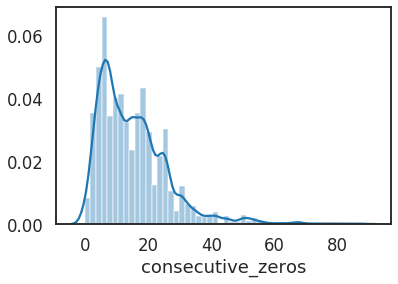

In [63]:
## check
# sns.distplot(df_temp_consecutive_step['consecutive_zeros'])
# df_temp_consecutive_step['consecutive_zeros'].describe()

In [64]:
df_actigraph = df_actigraph.merge(
    df_temp_consecutive_step[['index','consecutive_zeros','min_value','max_value','mean','stdev']],
    how = 'left',
    left_index = True,
    right_on = 'index'
)

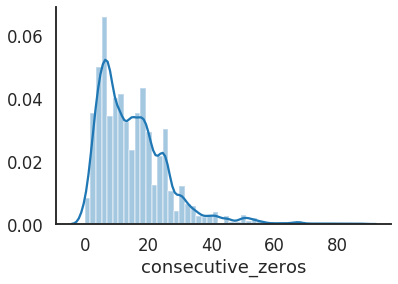

In [65]:
sns.distplot(
    df_actigraph['consecutive_zeros']
)
sns.despine();

Here, we assume if there are >= 88 consecutive zeros AND max value is greater than 100, we identify the observations as non-wear time.

**Note 2020-08-27: to be thought further: if max value >= 100, it should be artificial movement? non-wear tolerates < 100 cpm interruptions?**

In [66]:
conditions = [
    (df_actigraph['consecutive_zeros'] >= 88) & (df_actigraph['max_value'] >= 100)
]

choices = [
    'non-wear'
]

df_actigraph['device_usage_flag'] = np.select(
    conditions,
    choices,
    default = 'wear'
)

In [67]:
## reference: https://stackoverflow.com/a/55790765
window_minute = 30

df_actigraph['next_window_device_usage_flag'] = pd.Series(
    df_actigraph['device_usage_flag'].str.cat(
        [
            df_actigraph.groupby(
                ['patient_id','directory_name']
            ).shift(-i)['device_usage_flag'].fillna('NA') for i in range(1, window_minute)
        ],
        sep = ', '
    ),
)

In [68]:
## reference: https://stackoverflow.com/a/55790765
window_minute = 30

df_actigraph['previous_window_device_usage_flag'] = pd.Series(
    df_actigraph['device_usage_flag'].str.cat(
        [
            df_actigraph.groupby(
                ['patient_id','directory_name']
            ).shift(i)['device_usage_flag'].fillna('NA') for i in range(1, window_minute)
        ],
        sep = ', '
    ),
)

In [69]:
def determine_behavior_by_device_usage(series, 
                                       column_window_flag,
                                       column_zero='consecutive_zeros', 
                                       window_size=90,
                                       use_default_search_space_size=True,
                                      default_search_space_size=30):
    if use_default_search_space_size:
        search_space_size = default_search_space_size
    else:
        if pd.isnull(series[column_zero]):
            search_space_size = window_size
        else:
            search_space_size = np.int64(window_size - series[column_zero])
    search_space = series[column_window_flag].split(', ')[0:search_space_size]
    if 'non-wear' in search_space:
        return True
    else:
        return False

In [70]:
df_actigraph['next_window_device_usage_flag_contains_nonwear'] = df_actigraph[['consecutive_zeros','next_window_device_usage_flag']].apply(
    lambda x: determine_behavior_by_device_usage(x, column_window_flag='next_window_device_usage_flag'),
    axis=1
)

In [71]:
df_actigraph['previous_window_device_usage_flag_contains_nonwear'] = df_actigraph[['consecutive_zeros','previous_window_device_usage_flag']].apply(
    lambda x: determine_behavior_by_device_usage(x, column_window_flag='previous_window_device_usage_flag'),
    axis=1
)

In [72]:
def generate_final_behavior_attribute(series,
                                      device_usage_column,
                                      initial_behavior_column,
                                      next_window_nonwear_column,
                                      previous_window_nonwear_column):
    """
    Determine behavior based on the pattern of consecutive zeros and current axis1 value.
    If any of the device_usage_column in the next 30 minute equals to non-wear,
        or if any of the device_usage_column in the previous 30 minute equals to non-wear,
        or if current device_usage_column is non-wear,
        then set behavior as non_wear_time
    Else use the initial behavior column (based on the cutoffs)
    """
    if (
        (series[next_window_nonwear_column]) |
        (series[previous_window_nonwear_column]) | 
        (series[device_usage_column] == 'non-wear')
    ):
        return 'non_wear_time'
    else:
        return series[initial_behavior_column]

In [73]:
df_actigraph['behavior_final'] = df_actigraph.apply(
    lambda x: generate_final_behavior_attribute(
        x,
        device_usage_column='device_usage_flag',
        initial_behavior_column='behavior_by_rule',
        next_window_nonwear_column='next_window_device_usage_flag_contains_nonwear',
        previous_window_nonwear_column='previous_window_device_usage_flag_contains_nonwear'
    ),
    axis=1
)

In [75]:
## checkpoint
# df_actigraph.to_csv('../0-dataset/1-preprocessed/actigraph_combined_with_metadata_activity_type.csv', index = False)

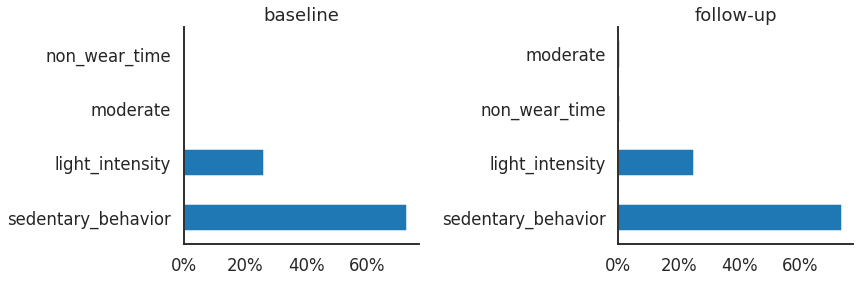

In [76]:
f, ax = plt.subplots(figsize = (12,4), ncols = 2)
plt.subplots_adjust(wspace = .85)
i = 0

for col in ['baseline','follow-up']:
    mask = (df_actigraph['directory_name'] == col)    
    df_actigraph.loc[
        mask,
        'behavior_final'
    ].value_counts(True).plot.barh(ax=ax[i]);
    
    x_values = ax[i].get_xticks()
    ax[i].set_xticklabels(['{:,.0%}'.format(x) for x in x_values])
    ax[i].set_title(col);
    i += 1
    
sns.despine()
plt.show();

In [77]:
d = df_actigraph.groupby([
    'behavior_final',
    'hour'
]).agg({
    'steps': 'count',
    'patient_id': 'nunique'
}).reset_index()

d_agg = d.groupby('hour').agg({
    'steps':'sum', 
    'patient_id':'max'
}).reset_index().rename(columns = {
    'steps':'step_record',
    'patient_id':'total_patient'
})

d = d.merge(
    d_agg,
    how='left',
    on='hour'
)

d['step_percentage'] = d['steps'] / d['step_record']
d['patient_percentage'] = d['patient_id'] / d['total_patient']

"non-wear" time are mostly observed between midnight to 1 PM. Wonder why?

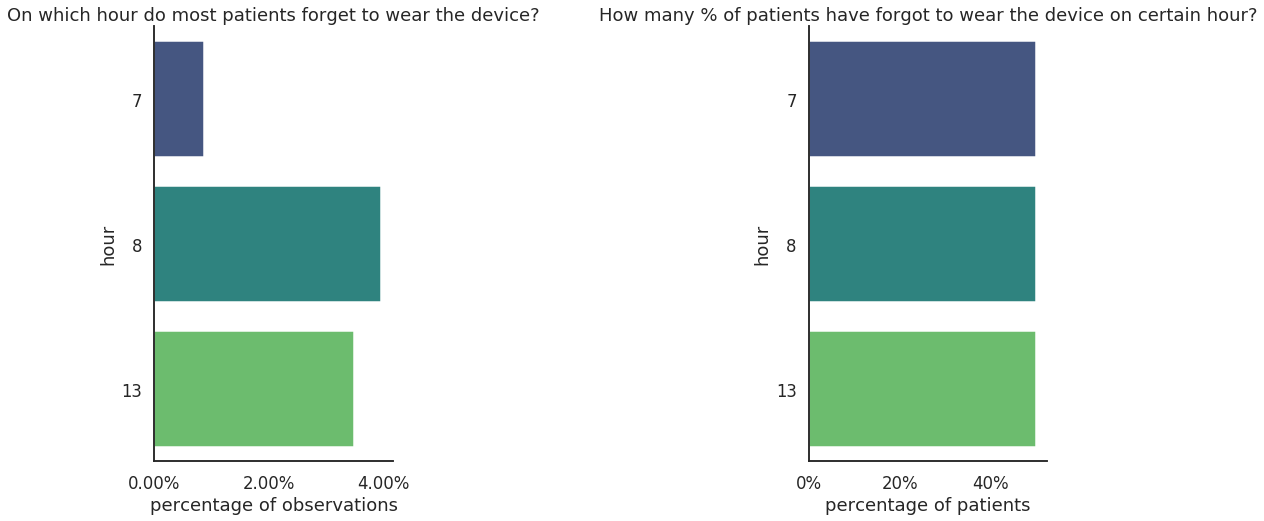

In [78]:
f, ax = plt.subplots(figsize = (16,8), ncols = 2)
plt.subplots_adjust(wspace = 1.75)

mask = (d['behavior_final'] == 'non_wear_time')
sns.barplot(
    data = d[mask],
    y = 'hour',
    x = 'step_percentage',
    orient = 'h',
    palette = 'viridis',
    ax = ax[0]
)
ax[0].set_title('On which hour do most patients forget to wear the device?')
ax[0].set_xlabel('percentage of observations')
x_values = ax[0].get_xticks()
ax[0].set_xticklabels(['{:,.2%}'.format(x) for x in x_values])

sns.barplot(
    data = d[mask],
    y = 'hour',
    x = 'patient_percentage',
    orient = 'h',
    palette = 'viridis',
    ax = ax[1]
)
ax[1].set_title('How many % of patients have forgot to wear the device on certain hour?')
ax[1].set_xlabel('percentage of patients')
x_values = ax[1].get_xticks()
ax[1].set_xticklabels(['{:,.0%}'.format(x) for x in x_values])
sns.despine();

# 3. Potential sleep time

**This section might be deleted!**

**Can we identify "sleep" based on the distribution of steps?**

Assumption: 
- We only identify "sleep" at night (night sleep hours: between 9 PM (inclusive) and 5 AM (inclusive))
    
Problem:
1. Some patients have fluctuative steps during night sleep hours, thus he/she could be identified as sleeping only for an hour, followed by normal activities, then sleep again. Hence, it is difficult to use the percentile as threshold.

In [79]:
def determine_sleep(df, hour_column = 'hour', metric = 'steps'):
    """
    Determine whether a patient is sleeping.
    Default metric: steps
    Assumption: 
    1. We only identify "sleep" at night (between 10 PM and 6 AM)
    2. If hourly step is lower than 75th percentile of metric during sleep hour, then it is considered as sleep
    """
    mask_sleep_hour = (df[hour_column] >= 21) | (df[hour_column] < 6)
    threshold = np.round(np.percentile(df[mask_sleep_hour][metric], q = 75))
    
    conditions = [
        (df[metric] < threshold) & mask_sleep_hour
    ]
    
    choices = [
        'Sleep'
    ]
    
    print('Threshold: {:,.0f} {}'.format(threshold, metric))
    result = np.select(conditions, choices, default = 'Not sleep')
    return result

In [80]:
mask_baseline = (df_actigraph_agg_hourly['directory_name'] == 'baseline')

sleep_result = determine_sleep(
    df = df_actigraph_agg_hourly[mask_baseline]
)

df_actigraph_agg_hourly.loc[
    mask_baseline,
    'sleep_flag'
] = sleep_result

sleep_result = determine_sleep(
    df = df_actigraph_agg_hourly[~mask_baseline]
)

df_actigraph_agg_hourly.loc[
    ~mask_baseline,
    'sleep_flag'
] = sleep_result

del sleep_result

Threshold: 43 steps
Threshold: 62 steps


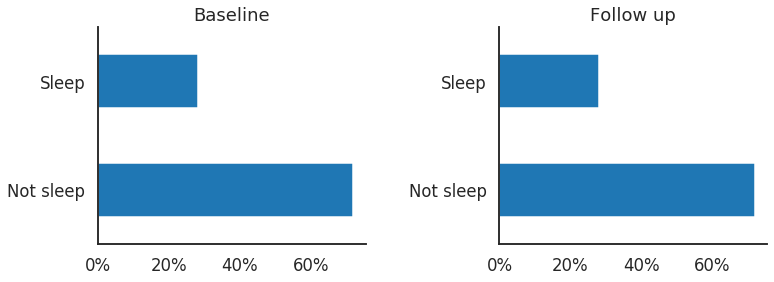

In [81]:
f, ax = plt.subplots(figsize = (12,4), ncols = 2)
plt.subplots_adjust(wspace = .5)

df_actigraph_agg_hourly[mask_baseline]['sleep_flag'].value_counts(True).plot.barh(
    ax=ax[0]
);
ax[0].set_title('Baseline')
x_values = ax[0].get_xticks()
ax[0].set_xticklabels(['{:,.0%}'.format(x) for x in x_values])

df_actigraph_agg_hourly[~mask_baseline]['sleep_flag'].value_counts(True).plot.barh(
    ax=ax[1]
);
ax[1].set_title('Follow up')
x_values = ax[1].get_xticks()
ax[1].set_xticklabels(['{:,.0%}'.format(x) for x in x_values])

sns.despine();